<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S7/ERA_S7_C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 228994102.40it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108544528.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71353019.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2699139.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# only 1 transition layer is good eneough..no patterns/parts of object visible..only edges and gradient.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model4().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
            Conv2d-2           [-1, 10, 24, 24]             910
         MaxPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4           [-1, 10, 10, 10]             910
            Conv2d-5             [-1, 16, 8, 8]           1,456
            Conv2d-6             [-1, 20, 6, 6]           2,900
            Conv2d-7             [-1, 10, 4, 4]           1,810
 AdaptiveAvgPool2d-8             [-1, 10, 1, 1]               0
Total params: 8,086
Trainable params: 8,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.03
Estimated Total Size (MB): 0.16
-------

In [17]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
model =  Model4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.3233895003795624 Batch_id=468 Accuracy=63.53: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]



Test set: Average loss: 0.1963, Accuracy: 9397/10000 (93.97%)

EPOCH: 1


Loss=0.07537177950143814 Batch_id=468 Accuracy=94.05: 100%|██████████| 469/469 [00:43<00:00, 10.83it/s]



Test set: Average loss: 0.1145, Accuracy: 9649/10000 (96.49%)

EPOCH: 2


Loss=0.02545301616191864 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [00:45<00:00, 10.34it/s]



Test set: Average loss: 0.0791, Accuracy: 9750/10000 (97.50%)

EPOCH: 3


Loss=0.15758804976940155 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]



Test set: Average loss: 0.0666, Accuracy: 9784/10000 (97.84%)

EPOCH: 4


Loss=0.0401279591023922 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]



Test set: Average loss: 0.0603, Accuracy: 9803/10000 (98.03%)

EPOCH: 5


Loss=0.07301286607980728 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0514, Accuracy: 9829/10000 (98.29%)

EPOCH: 6


Loss=0.02987246960401535 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:45<00:00, 10.40it/s]



Test set: Average loss: 0.0589, Accuracy: 9799/10000 (97.99%)

EPOCH: 7


Loss=0.07977359741926193 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:44<00:00, 10.62it/s]



Test set: Average loss: 0.0524, Accuracy: 9825/10000 (98.25%)

EPOCH: 8


Loss=0.02240910194814205 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:43<00:00, 10.88it/s]



Test set: Average loss: 0.0418, Accuracy: 9854/10000 (98.54%)

EPOCH: 9


Loss=0.1003580316901207 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0440, Accuracy: 9848/10000 (98.48%)

EPOCH: 10


Loss=0.026097649708390236 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:45<00:00, 10.31it/s]



Test set: Average loss: 0.0352, Accuracy: 9873/10000 (98.73%)

EPOCH: 11


Loss=0.06750204414129257 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:44<00:00, 10.64it/s]



Test set: Average loss: 0.0416, Accuracy: 9860/10000 (98.60%)

EPOCH: 12


Loss=0.07491695135831833 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:50<00:00,  9.30it/s]



Test set: Average loss: 0.0382, Accuracy: 9877/10000 (98.77%)

EPOCH: 13


Loss=0.09828269481658936 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:43<00:00, 10.81it/s]



Test set: Average loss: 0.0357, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.21168553829193115 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:46<00:00, 10.17it/s]



Test set: Average loss: 0.0346, Accuracy: 9884/10000 (98.84%)



Text(0.5, 1.0, 'Test Accuracy')

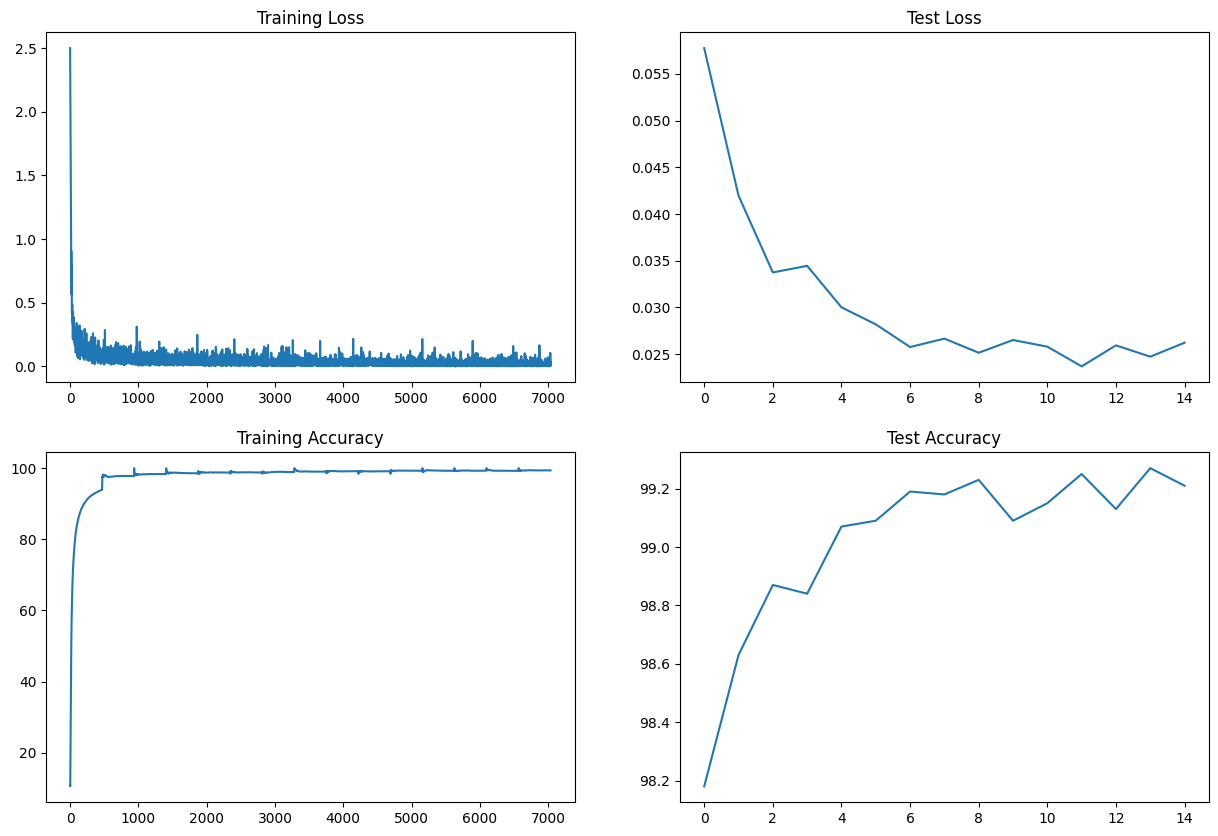

In [ ]:
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**


1.   Keep the parameters around 8000. Introduce GAP, image augmentation to reduce overfitting. Use the space provided by GAP- to increase parameters.



**Result:**

1.   Parameters: 8,086
2.   Best Train Accuracy: 98.5
3.   Best Test Accuracy: 98.84


**Analysis:**


1.   Introduce Batch Normalization to stabilize the training. Need to introduce LR on schedule to reach optima.

